# An equity cliquet contract


Pre-requisites: Notebook 1.1, 1.2

In this notebook we will create and price an **accumulator clique** and in that process learn to 

- use a **snapper** for contracts with path dependent calculations.
- create a timetable with `expressions`

Let us start with the imports.

In [ ]:
from datetime import datetime

import numpy as np
import pandas as pd
from finmc.models.heston import HestonMC
from matplotlib import pyplot as plt
from pyarrow import RecordBatch as rb
from qablet.base.flags import Stats
from qablet.base.mc import MCPricer
from qablet_contracts.timetable import TS_EVENT_SCHEMA, py_to_ts

## Create the contract

The payoff of an accumulator depends on the returns of an asset over several time periods $T_0 < T_1 < ... T_N$. 

If the returns are given by

$$
r_i = \frac{S_{T_{i+1}}-S_{T_i}}{S_{T_i}}
$$

The contract has a single payoff at $T_N$ is given by

$$
\max \left( 0, \Sigma_0^{N-1} \max(\min(r_i, cap), floor) \right)
$$

To calculate this payoff we will use two path dependent numbers called **snaps**.

 - `S_LAST` to keep track of the last known fixing of the stock
 - `A` to keep track of the accumutated return so far

In [ ]:
# Accumulator Cliquet parameters
global_floor = 0.0
# calculate returns every six months for 3 years
fix_dts = pd.bdate_range(
    datetime(2021, 12, 31),
    datetime(2024, 12, 31),
    freq="2BQE",
    inclusive="both",
)
local_floor = -0.03
local_cap = 0.05
ccy = "USD"
asset = "SPX"

The first event is a **snapper** named `INIT` which initializes the **snaps** `S_LAST` and `A`. We will define the `INIT` a little later. A snapper event has no impact on the contract itself.

In [ ]:
events = [
    {
        "track": None,
        "time": fix_dts[0],
        "op": "s",
        "quantity": 0,
        "unit": "INIT",  # initialize accumulator
    }
]

It is followed by a series of **snapper** events at each fixing time, which updates the accumulator `A` and the last fixing value. 

In [ ]:
for fix_dt in fix_dts[1:]:
    events.append(
        {
            "track": None,
            "time": fix_dt,
            "op": "s",
            "quantity": 0,
            "unit": "UPDATE",  # update accumulator
        }
    )

Then, at maturity, we apply the global floor, which is an option for the holder of the contract to receive the floor, instead of the accumulator payoff. 

In [ ]:
maturity = fix_dts[-1]

events.append(
    {
        "track": "",
        "time": maturity,
        "op": ">",  # global floor
        "quantity": global_floor,
        "unit": ccy,
    }
)

Finally, the last event is a payment based on the accumulator. This is expressed by having `A` in the unit column.

In [ ]:
events.append(
    {
        "track": "",
        "time": maturity,
        "op": "+",  # pay the accumulated amount
        "quantity": 1,
        "unit": "A",
    }
)

From this list we can create the events arrow table using the `RecordBatch.from_py_list` method from the `pyarrow` package.

In [ ]:
events_table = rb.from_pylist(events, schema=TS_EVENT_SCHEMA)
print(events_table.to_pandas())

                       time op  quantity    unit track
0 2021-12-31 00:00:00+00:00  s       0.0    INIT   NaN
1 2022-06-30 00:00:00+00:00  s       0.0  UPDATE   NaN
2 2022-12-30 00:00:00+00:00  s       0.0  UPDATE   NaN
3 2023-06-30 00:00:00+00:00  s       0.0  UPDATE   NaN
4 2023-12-29 00:00:00+00:00  s       0.0  UPDATE   NaN
5 2024-06-28 00:00:00+00:00  s       0.0  UPDATE   NaN
6 2024-12-31 00:00:00+00:00  s       0.0  UPDATE   NaN
7 2024-12-31 00:00:00+00:00  >       0.0     USD      
8 2024-12-31 00:00:00+00:00  +       1.0       A      


We are not done, because we have not defined `INIT` and `UPDATE` yet. We define a snapper using a dict of four components.

In [ ]:
def accumulator_init_fn(inputs):
    [s] = inputs
    return [0, s]  # [A, S_last]


init = {
    "type": "snapper",
    "inp": [asset],  # what assets should go as inputs to the snapper fn
    "fn": accumulator_init_fn,  # the snapper fn
    "out": [
        "A",
        "S_last",
    ],  # what snaps should store the output of the snapper fn
}

Similarly,

In [ ]:
def accumulator_update_fn(inputs):
    [s, s_last, a] = inputs

    ret = s / s_last - 1.0  # ret = S / S_last - 1
    ret = np.maximum(local_floor, ret)
    ret = np.minimum(local_cap, ret)

    return [a + ret, s]  # [A, S_last]


update = {
    "type": "snapper",
    "inp": [
        asset,
        "S_last",
        "A",
    ],  # what assets, or previous snaps should go as inputs to the snapper fn
    "fn": accumulator_update_fn,  # the snapper fn
    "out": [
        "A",
        "S_last",
    ],  # what snaps should store the output of the snapper fn
}

For more details see [Snapper API](https://qablet.github.io/qablet-contracts/specifications/snapper/)

Now we have all components needed to define our timetable. Unlike previous examples, where the timetable only had `events`, this time has another component called `expressions`.


In [ ]:
timetable = {
    "events": events_table,
    "expressions": {
        "INIT": init,
        "UPDATE": update,
    },
}

## Calculate Price (Heston)

To price this contract, we can use the `HestonMC` from the finmc package that we used to price the vanilla option contract. Recall that this model requires HESTON model parameters to be included in the dataset. However, this part is independent of the contract, so we can use the same dataset that we used for the vanilla option.

In [ ]:
times = np.array([0.0, 1.0, 2.0, 5.0])
rates = np.array([0.04, 0.04, 0.045, 0.05])
discount_data = ("ZERO_RATES", np.column_stack((times, rates)))

spot = 2900
div_rate = 0.01
fwds = spot * np.exp((rates - div_rate) * times)
fwd_data = ("FORWARDS", np.column_stack((times, fwds)))

heston_dataset = {
    "MC": {
        "PATHS": 100_000,
        "TIMESTEP": 1 / 250,
        "SEED": 1,
    },
    "BASE": "USD",
    "PRICING_TS": py_to_ts(datetime(2021, 12, 31)).value,
    "ASSETS": {"USD": discount_data, "SPX": fwd_data},
    "HESTON": {
        "ASSET": "SPX",
        "INITIAL_VAR": 0.0654,
        "LONG_VAR": 0.0707,
        "VOL_OF_VOL": 0.2928,
        "MEANREV": 0.6067,
        "CORRELATION": -0.7571,
    },
}
model = MCPricer(HestonMC)
price, _ = model.price(timetable, heston_dataset)
print(f"price: {price:11.6f}")

price:    0.082519


## Pricing Stats
As we saw in the vannial option notebok, we can use the `PV_VEC` flag to get the distribution of prices.

In [ ]:
heston_dataset["MC"]["FLAGS"] = Stats.PV_VEC
price, stats = model.price(timetable, heston_dataset)
print(f"price: {price:11.6f}")
print(f"stats: {stats}")

price:    0.082519
stats: {'PV_VEC': array([0.11115008, 0.        , 0.        , ..., 0.19059449, 0.1212874 ,
       0.19059449])}


We can use this data to get the standard deviation of the simulation.

In [ ]:
pv_vec = stats["PV_VEC"]
print(f"std = {pv_vec.std():.6f}")
print(f"max = {pv_vec.max():.6f}")
print(f"min = {pv_vec.min():.6f}")

std = 0.069465
max = 0.259902
min = 0.000000


We can use this data to plot the probability density.

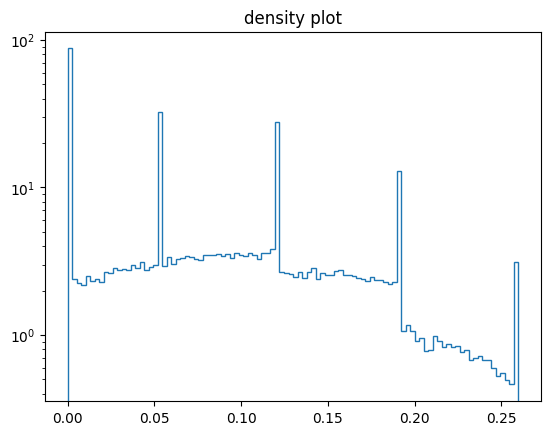

In [ ]:
plt.hist(pv_vec, bins=100, density=True, histtype="step", log=True)
plt.title("density plot")
plt.show()

## Suggested Exercises and Other Reading

- Create and price a Napolean Option, where the payoff at maturity is a fixed Coupon plus the minimum of the returns of each period.
- Create and price a forward starting option.
- See Project [qatwalk/eq](https://github.com/qatwalk/eq) for comparisons of many exotic derivatives (cliquets, forward collars, lookback options) using a number of different models.

Next: [Vanilla Swaption](1_4_vanilla_swaption.ipynb)